In [4]:
import numpy as np
# from numpy import matlib
import scipy.stats
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'


# transcription models

In [47]:
def simulate_GOU_transcription(K0, t0, tf, dt, params, random_seed = None):
    beta, gamma, a, kappa, theta = params
    
    N=int(ceil((tf-t0)/dt))
    T=np.arange(t0, tf+dt, dt)
    
    K = np.zeros(len(T))
    K[0] = K0
    
    epsilon = 1e-6       # to prevent singularities in gamma distribution call when n = 0

    if isinstance(random_seed, int):
        np.random.seed(random_seed)
    
    # Directly simulate GOU via Euler-Maruyama time steps
    for i in range(len(K) - 1):
        n = poisson.rvs(mu=a*dt) + epsilon
        r = gammadist.rvs(a=n, scale=theta)
        
        K[i+1] = K[i] - kappa*dt*K[i] + r
    return K, T



# Simulate the CIR transcription rate model
def simulate_CIR_transcription(K0, t0, tf, dt, params, random_seed = None):
    
    # initial array and unfold parameters of CIR process
    N=int(ceil((tf-t0)/dt))
    T=np.arange(t0, tf+dt, dt)
    K=np.zeros(N+1)
    K[0]=K0
    beta, gamma, a, kappa, theta = params
  
    # precompute parameters
    exph = exp(-kappa*dt)
    K_avg = (a*theta)/kappa
    sigma_2 = 2*kappa*theta

    l_ = 4*kappa*exph / (sigma_2 * (1-exph)) #non-centrality patameter
    d = 4*K_avg*kappa/sigma_2 #degree of freedom
    c = sigma_2*(1-exph)/(4*kappa)

    # generate random variables
    if isinstance(random_seed, int):
        np.random.seed(random_seed)
    Z = np.random.normal(loc=0,scale=1, size=[N,2])
    log_U = np.log(np.random.uniform(low=0.0, high=1.0, size=N))
    chi = np.random.gamma(shape=d/2, scale=2, size=N)

    for i in range(N):
        s = l_ * K[i] + 2*log_U[i]
        if s <= 0:
            Y = 0
        else:
            Y = (Z[i,0] + sqrt(s))**2 + Z[i,1]**2
        K[i+1] = c * (chi[i] + Y)

    return K, T



def simulate_tele_transcription(init_state, t0, tf, dt, params, random_seed = None):
    
    # initial array and unfold parameters of CIR process
#     N=int(ceil((tf-t0)/dt))
#     T=np.arange(t0, tf+dt, dt)
#     K=np.zeros(N+1)
#     K[0]=K0
    beta, gamma, kon,koff,kinit = params

    t = t0
    state = init_state
    K = [init_state*kinit]
    T = [t0]
    
    while t<tf:
        K.append(state*kinit)
        if state == 0:
            state = 1
            t += np.random.exponential(1/kon)
        elif state ==1:
            state = 0
            t += np.random.exponential(1/kon)
        T.append(t)
        T.append(t)
        K.append(state*kinit)
    return K, T


In [48]:
def convert_xy_to_params(x, y, beta, gamma, K_avg):
    kappa = (beta + gamma)*(x/(1-x))
    a_over_th = 1/y - 1
    theta = np.sqrt(kappa*K_avg/a_over_th)
    a = K_avg*kappa/theta
    return beta, gamma, a, kappa, theta
def convert_xy_to_params_tele(x,y,beta,gamma,K_avg):
    kappa = (beta+gamma)*(x/(1-x))
    ath = 1/y - 1
    c = K_avg*ath/kappa
    kon = np.sqrt(c) * kappa/ (np.sqrt(c) + 1)
    koff = kappa / (np.sqrt(c) + 1)
    kinit = K_avg * kappa / kon
    return beta,gamma,kon,koff,kinit


beta, gamma = 1, 1.2     # beta: splicing rate; gamma: mature degradation rate; units of 1/hours arbitrarily chosen
K_avg = 10               # average transcription rate for all parameter sets

x,y = 0.9,0.8
params_highgain = convert_xy_to_params(x, y, beta, gamma, K_avg)
params_highgain_tele = convert_xy_to_params_tele(x,y,beta,gamma,K_avg)

In [50]:
import numpy as np
from scipy.fft import irfft, irfftn
from scipy.stats import norm
from scipy.stats import nbinom, poisson
from scipy.stats import gamma as gammadist
import scipy.io as sio
from math import log, exp, sqrt, ceil

random_seed = 0
np.random.seed(random_seed)


t0, tf = 0, 7            # transcription rate simulation start and end time
start, end = 0,10000     # transcription rate trajectory plot start and end time (index)
t1, t2 = 4000, 4500    # times to visualize transcription rate with cell cartoons

max_rate = np.amax([params_lowgain, params_fastrev, params_highgain, params_slowrev])
dt = 0.1/max_rate        # simulation time step

max_K = 700              # manually chosen y axis upper bound for the high gain plots

poissonlike_colors = ['green', 'limegreen', 'lime', 'springgreen', 'seagreen']
overdispersed_colors = ['orange', 'moccasin', 'darkorange', 'burlywood', 'bisque']



num_examples = 8   # don't change this; needs to be at least 8 for the cell cartoon plotting to work properly

# print("dt: ", dt, " hours")
print()

# ======================================


beta, gamma, a, kappa, theta = params_highgain
alpha = K_avg/theta
K0 = gammadist.rvs(a=alpha, scale=theta,size=num_examples)
i=0
K_CIR, T_CIR = simulate_CIR_transcription(K0[i], t0, tf, dt, params_highgain)


beta, gamma, a, kappa, theta = params_highgain
alpha = K_avg/theta
K0 = gammadist.rvs(a=alpha, scale=theta,size=num_examples)
i=0
K_GOU, T_GOU = simulate_GOU_transcription(K0[i], t0, tf, dt, params_highgain)



beta,gamma,kon,koff,kinit = params_highgain_tele
# alpha = K_avg/theta
# K0 = gammadist.rvs(a=alpha, scale=theta,size=num_examples)
i=0

# K_GOU, T_GOU = simulate_GOU_transcription(K0[i], t0, tf, dt, params_highgain)

K_tele, T_tele = simulate_tele_transcription(0, t0, tf, dt, params_highgain_tele)


In [59]:
# lw=4
# model_colors = ['mediumpurple','mediumaquamarine','orchid']
# model_names = ('PFR fit','CSTR fit','LFR fit')
model_colors = ['cadetblue','limegreen','goldenrod']

fs = 26
lw=2
# linecol = 'k'
dims = (8,8)

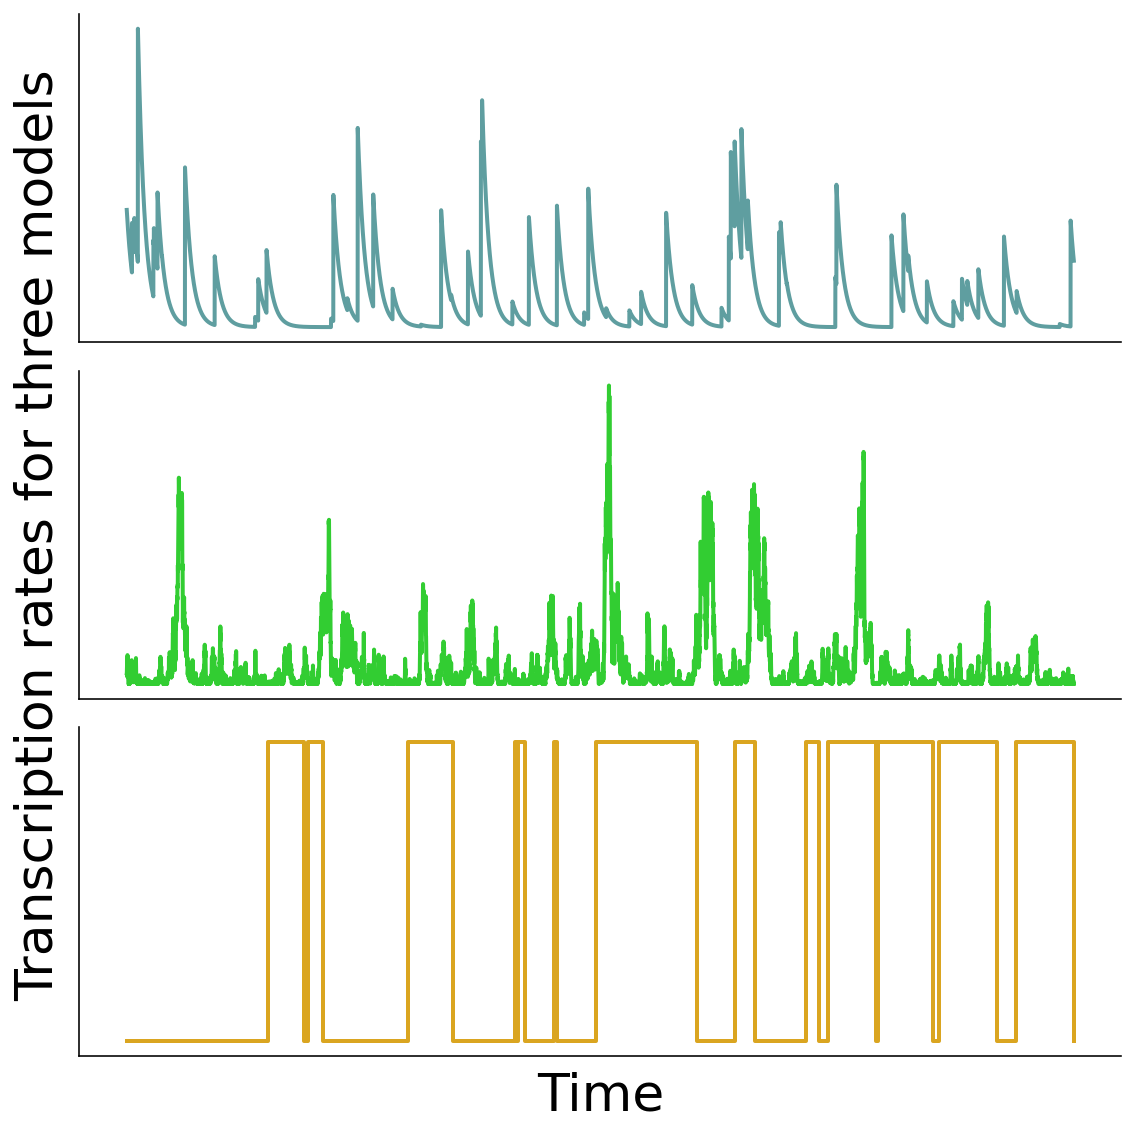

In [60]:
fig1,ax1 = plt.subplots(3,1,figsize=dims)

T = 2
t_ = np.linspace(0,5,100)


#############
ax1[0].plot(T_GOU,K_GOU,c=model_colors[0],linewidth=lw)
ax1[0].set_yticks([])
ax1[0].set_xticks([])

# #############
ax1[1].plot(T_CIR,K_CIR,c=model_colors[1],linewidth=lw)
ax1[1].set_yticks([])
ax1[1].set_xticks([])

# ##############

ax1[2].plot(T_tele,K_tele,c=model_colors[2],linewidth=lw)
ax1[2].set_yticks([])
ax1[2].set_xticks([])

ax1[2].set_xlabel('Time',fontsize=fs)
ax1[1].set_ylabel('Transcription rates for three models',fontsize=fs)
ax1[0].spines[['right', 'top']].set_visible(False)
ax1[1].spines[['right', 'top']].set_visible(False)
ax1[2].spines[['right', 'top']].set_visible(False)

plt.tight_layout()


plt.savefig('figs/fig1d_txmodels.png',dpi=450)
plt.savefig('figs/fig1d_txmodels.pdf')


# reactor models

In [5]:
def cstr_ppf(x,T):
    t = np.ones_like(x)
    for k in range(len(t)):
        if k==0:
            x0 = 0.0
        else:
            x0 = t[k-1]
        t[k] = scipy.optimize.minimize(lambda t_: (x[k]-(t_*scipy.special.exp1(t_)+1 -np.exp(-t_)))**2,x0=x0, 
                        bounds=scipy.optimize.Bounds(1e-12,np.inf)).x[0]
    t *= T
    return t

def lfr_ppf(x,T):
    t = np.ones_like(x)
    t[x<=2/3] = 3*T*x[x<=2/3]/4
    t[x>2/3] = T*np.sqrt(1/(12*(1-x[x>2/3])))
    return t

In [25]:
lw=4
model_colors = ['mediumpurple','mediumaquamarine','orchid']
model_names = ('PFR fit','CSTR fit','LFR fit')

fs = 26
lw=4
dims = (8,8)

In [26]:
nsim = 10000


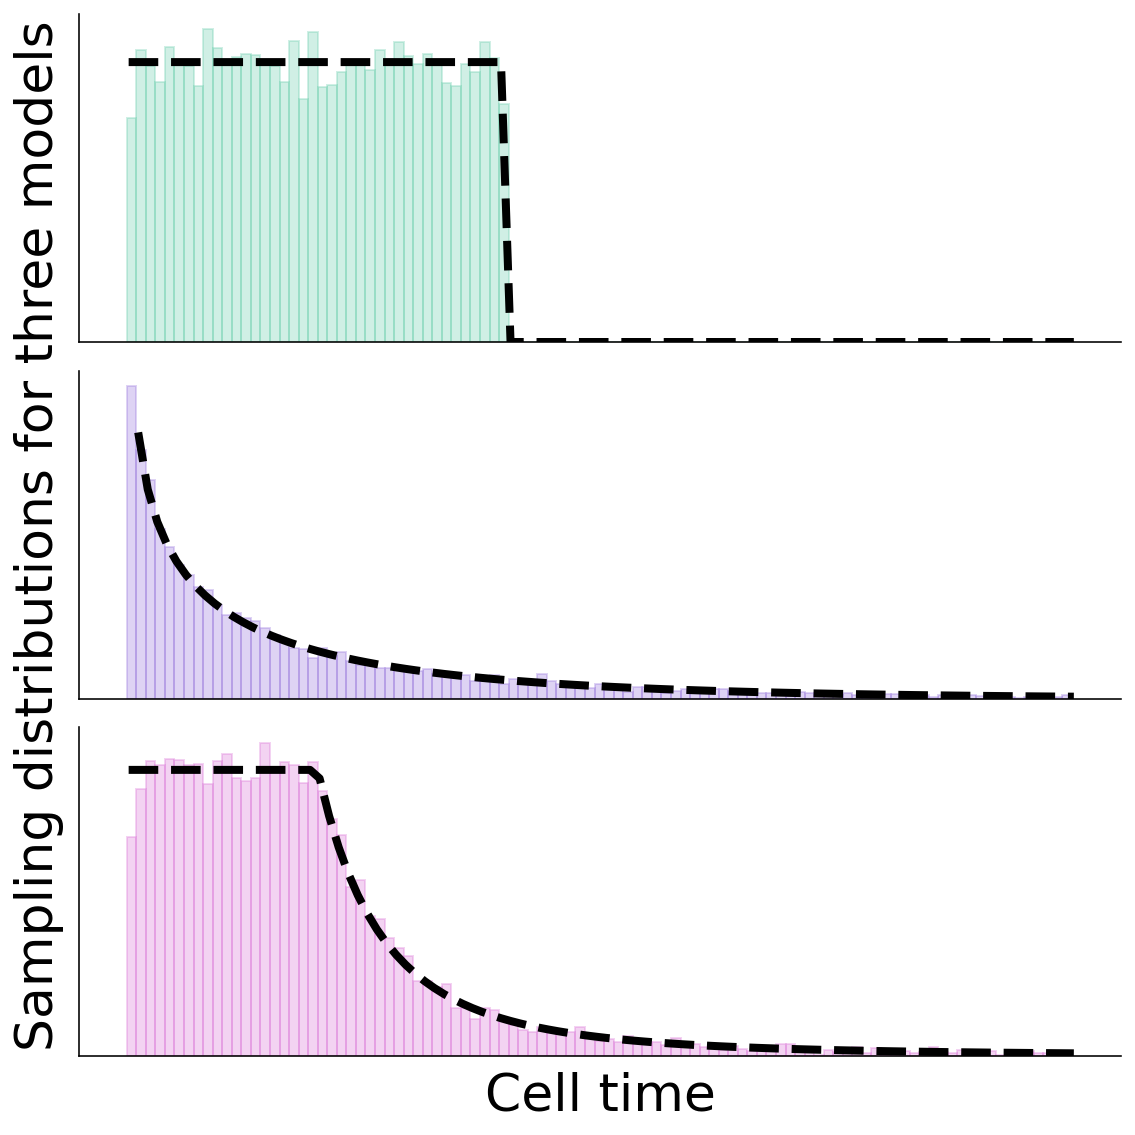

In [29]:
fig1,ax1 = plt.subplots(3,1,figsize=dims)

T = 2
t_ = np.linspace(0,5,100)


#############
restime_uni = np.zeros_like(t_)
restime_uni[t_<= T] = 1/T
ax1[0].plot(t_,restime_uni,'k--',linewidth=lw)

restime_sim = (scipy.stats.uniform(0,T).rvs(nsim))
bins = t_-0.01
_=ax1[0].hist(restime_sim,bins,density=True,facecolor=model_colors[1],alpha=0.3,edgecolor=model_colors[1])
ax1[0].set_yticks([])
ax1[0].set_xticks([])

#############

restime_exp = scipy.special.exp1(t_/T)/T
ax1[1].plot(t_,restime_exp,'k--',linewidth=lw)
restime_sim = scipy.stats.uniform(0,scipy.stats.expon(0,T).rvs(nsim)).rvs()
bins = t_-0.01

_=ax1[1].hist(restime_sim,bins,density=True,facecolor=model_colors[0],alpha=0.3,edgecolor=model_colors[0])
ax1[1].set_yticks([])
ax1[1].set_xticks([])

##############


restime_lfr = np.zeros_like(t_)
restime_lfr[t_<= T/2] = 4/3/T
restime_lfr[t_> T/2] = T**2/(t_[t_> T/2])**3/6
ax1[2].plot(t_,restime_lfr,'k--',linewidth=lw)
restime_sim = T/(2*np.sqrt(1-(scipy.stats.uniform().rvs(nsim)))) * scipy.stats.uniform().rvs(nsim)
bins = t_-0.01
_=ax1[2].hist(restime_sim,bins,density=True,facecolor=model_colors[2],alpha=0.3,edgecolor=model_colors[2])
# ax1.set_xlabel('Process time',fontsize=fs)
# ax1.set_ylabel('Density',fontsize=fs)
ax1[2].set_yticks([])
ax1[2].set_xticks([])
# ax1[2].set_xticks([0,T/2,T,2*T],['0',r'$T/2$',r'$T$',r'$2T$'],fontsize=fs)
ax1[2].set_xlabel('Cell time',fontsize=fs)
ax1[1].set_ylabel('Sampling distributions for three models',fontsize=fs)
ax1[0].spines[['right', 'top']].set_visible(False)
ax1[1].spines[['right', 'top']].set_visible(False)
ax1[2].spines[['right', 'top']].set_visible(False)

plt.tight_layout()


plt.savefig('figs/fig1d_reactors.png',dpi=450)
plt.savefig('figs/fig1d_reactors.pdf')
